<a href="https://colab.research.google.com/github/zubayr1/NLP_Project_2021/blob/main/Task2_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2: Sentiment Classiﬁer & Transfer Learning  (10 points)


### Imports

This code block is reserved for your imports. 

You are free to use the following packages: 

(List of packages) 

In [ ]:
from google.colab import files
import pandas as pd
import io
import string

import time
import gc
from google.colab import drive

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!rm -rf /content/zk_packages

!git clone https://github.com/zubayr1/zk_packages

import zk_packages.modules as modules

Cloning into 'zk_packages'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 44 (delta 17), reused 41 (delta 14), pack-reused 0
Unpacking objects: 100% (44/44), done.


## 2.a) Binary neural sentiment classiﬁer: 

---


Implement a binary neural sentiment classiﬁer for the Hindi section of the corpus. 
Use your word embeddings from Task 1 for that. So first load the saved model.

Upload the file

In [ ]:
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['hindi_hatespeech.tsv']),  sep='\t')

Saving hindi_hatespeech.tsv to hindi_hatespeech (1).tsv


Prepare the data to remove usernames, punctuations and stopwords

In [ ]:
def data_preperation(data):
  #TODO: implement!

  #remove User names

  data.loc[:, 'text'] =  data.loc[:, 'text'].str.replace('(@\w+.*?)',"")



  #remove Punctuations

  data.loc[:, 'text'] = data.loc[:,'text'].str.replace('[{}]'.format(string.punctuation), "")
  data.loc[:, 'text'] = data.loc[:,'text'].str.replace(r'\+', "") 
  data.loc[:, 'text'] = data.loc[:,'text'].str.replace('।', "") 
  data.loc[:, 'text'] = data.loc[:,'text'].str.replace('…', "")


  #remove Stopwords
  !rm -rf /content/stopwords-hi

  !git clone https://github.com/stopwords-iso/stopwords-hi


  f=open("/content/stopwords-hi/stopwords-hi.txt", "r")

  if f.mode == 'r':
    contents =f.read()

  newcontent = contents.split()



  data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (newcontent)]))

  

  #lowercasing the words

  data['text'] = data['text'].str.lower()


  return data

df = data_preperation(df)

Cloning into 'stopwords-hi'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), done.


###Get Words list and Vocabulary

In [ ]:
WORDSINLIST, V = modules.building_vocabulary(df, 'text')

###Initialize Cuda

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


###Create a custom dataset out  of the main dataset so that it can return the text and hatespeech based on some index

First we padded the indexed sentence to 30 words.
Next we made one hot of each word in the sentence.

For the indexed hatespeech, we made a tensor(0.0) if it is NOT or tensor(1.0) if it is HOF.

Both the tensors are sent to device is is CUDA or CPU based on whether CUDA is available.

In [ ]:
class CustomDataset():
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

 

    sentence = self.df['text'][idx]
    target = self.df['task_1'][idx]


    paddedstr=""
    if len(sentence.split())>=30:
      sentencelist =  sentence.split()[:30]
      sentencestr = ' '.join(sentencelist)
      paddedstr+=sentencestr
    else:
      while len(sentence.split())<30:
        sentence = sentence + ' 0'
      paddedstr+=sentence


    paddedlist = paddedstr.split()


    one_hot_list=[]

    for current in paddedlist:
      current_one_hot = modules.word_to_one_hot(current, V)
      one_hot_list.append(current_one_hot)



    one_hot_list = one_hot_list[:30]
    one_hot_list = torch.FloatTensor(one_hot_list)

    hatespeech = 0
    if target in 'NOT':
      hatespeech=0.0
    else:
      hatespeech = 1.0

    hatespeech = torch.tensor(hatespeech)



    one_hot_list = one_hot_list.to(device)
    hatespeech = hatespeech.to(device)


    return one_hot_list, hatespeech
  

In [ ]:
customds = CustomDataset(df)

In [ ]:
count=0
for i, j in customds:
  count+=1
  if count==4:
    break
  print(i.shape,  j)


torch.Size([30, 19365]) tensor(0.)
torch.Size([30, 19365]) tensor(1.)
torch.Size([30, 19365]) tensor(1.)


###Split test and train dataset. 
We make 80% of the data for train dataset and 20% of the data for test dataset


In [ ]:
train_size = int(0.8 * len(customds))
test_size = len(customds) - train_size


We have created both test and train Dataloader

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(customds, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size= 64, shuffle = False, num_workers=0)
testloader = DataLoader(test_dataset, batch_size= 64, shuffle = False, num_workers=0)

### We fixed some parameters and hyperparameters.

In [ ]:
embedding_size = 300
learning_rate = 0.03

epochs = 10

### We create instance of the same model that we used in Task1

In [ ]:
model = modules.Word2vec( 19365, embedding_size)


Now we load the model that we saved in task1.

In [ ]:
PATH = "modelnew.pt"

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

Word2vec(
  (FC1): Linear(in_features=19365, out_features=300, bias=False)
  (FC2): Linear(in_features=300, out_features=19365, bias=False)
)

###We created a new model that we will use for sentiment analysis
2 of the model weights are from the old model loaded in the last step.

To get a complex Neural Network with many hidden layers, we have included some layers with batch norm and dropouts.

We also have implemented ReLu to gain non linearity.

In [ ]:
class Classification(nn.Module):
    def __init__(self, LENGTH, embedding_size):
      super(Classification, self).__init__()
      self.LENGTH = LENGTH
      self.embedding_size = embedding_size

      self.inputl = nn.Linear(self.LENGTH*30, embedding_size,0) # (LENGTH*30, 300)

     # initialization of weights
      torch.nn.init.xavier_normal_(self.inputl.weight) 

      self.FC1 = model.FC1.weight # (300, 19365)
      self.BN1 = nn.BatchNorm1d(19365)

      self.FC2 = model.FC2.weight # (19365, 300)
      self.BN2 = nn.BatchNorm1d(300)
      
      self.FC3 = nn.Linear(300, 1000,0) # (300, 1000)
      self.BN3 = nn.BatchNorm1d(1000)

      self.FC4 = nn.Linear(1000, 2000,0) # (1000, 2000)
      self.BN4 = nn.BatchNorm1d(2000)

      self.FC5 = nn.Linear(2000, 100,0) # (2000, 100)
      self.BN5 = nn.BatchNorm1d(100)

      self.FC6 = nn.Linear(100, 1,0) # (100, 1)

      # initialization of weights
      #torch.nn.init.xavier_normal_(self.output.weight)
      self.drop1 = nn.Dropout2d(p=0.8)
      self.drop2 = nn.Dropout2d(p=0.5)

    def forward(self, one_hot): # one_hot: (64, 30, LENGTH)

      # print(one_hot.shape)
      one_hot = one_hot.reshape(len(one_hot), 30 * self.LENGTH)

      x = self.inputl(one_hot)
      x= F.relu(x)

      x = torch.matmul(x, self.FC1)
      x = self.BN1(x)
      x= F.relu(x)

      x = torch.matmul(x, self.FC2)
      x = self.BN2(x)
      x= F.relu(x)

      x = self.FC3(x)
      x = self.BN3(x)
      x= F.relu(x)
      x = self.drop1(x)

      x = self.FC4(x)
      x = self.BN4(x)
      x= F.relu(x)

      x = self.FC5(x)
      x = self.BN5(x)
      x= F.relu(x)
      x = self.drop2(x)

      x = self.FC6(x)

      m = nn.Sigmoid()
      x = m(x)

      return x

Created an instance of the class

In [ ]:
classification = Classification(len(V), embedding_size)

### We define the Optimizer and the Criterion (loss function).

In [ ]:
optimizer = torch.optim.Adam(classification.parameters(), lr = learning_rate)

criterion = nn.BCELoss()

In [ ]:
classification = classification.to(device)
criterion = criterion.to(device)

###Now we train the model


In [ ]:
#train the model..
AVG_LOSS_LIST = []
AVG_TIME = []
def train(train_dl, LENGTH):
    print("Training started")
    lastone = 9999
    
    for epoch in range(epochs):
        start_time = time.time()
        avg_loss = 0
        count = 0

        for xb,yb in train_dl: 

          xb = xb.to(device)
          yb = yb.to(device)

         
          
          # 1. Generate predictions
          optimizer.zero_grad()
          print('New x, label generated')

          print(yb.shape)
        
          pred = classification(xb)

         
          # 2. Calculate loss
          
          yb = yb.unsqueeze(1)

          loss = criterion(pred, yb)

         
          avg_loss+=loss
          count+=1
          # 3. Compute gradients
          loss.backward()
              
          # 4. Update parameters using gradients
          optimizer.step()
              
          # 5. Reset the gradients to zero
          #optimizer.zero_grad()
        
        

        # Print the progress
        print('avg loss at epoch ', epoch, ' ', avg_loss/count)
        remaining = (time.time() - start_time)
        print("--- %s seconds ---" % remaining)
        AVG_LOSS_LIST.append(avg_loss/count)
        AVG_TIME.append(remaining)

        # Terminating Condition
        if (avg_loss/count)> lastone:
          return
        lastone = (avg_loss/count)

train(trainloader, len(V))

print("Training finished")

Training started
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated


### Next we test the model.

In [ ]:
#test the model..
AVG_LOSS_LIST = []
AVG_TIME = []


def test(test_dl, LENGTH):
    print("Testing started")

    start_time = time.time()
    avg_loss = 0
    count = 0
    hitcount=0
    for xb,yb in test_dl: 
      
      
      # 1. Generate predictions
      optimizer.zero_grad()
      # print(xb.shape)
    
      pred = classification(xb)

      

      # pred = pred.squeeze(1)


      # if (pred - yb)==0:
      #   hitcount=hitcount+1

      # print(pred)
      # print(yb)

      ybcount=-1
      for i in pred:
        
        count+=1
        ybcount+=1
        # print(i, yb[ybcount])
        if i <0.5:
          if torch.eq(yb[ybcount], torch.tensor(0.0)):
            hitcount=hitcount+1
        elif i>=.5:
          if torch.eq(yb[ybcount], torch.tensor(1.0)):
            hitcount=hitcount+1



      

      # 2. Calculate loss
      
      yb = yb.unsqueeze(1)

      loss = criterion(pred, yb)


      avg_loss+=loss
      

 

    # Print the progress
    print('avg loss at epoch ', avg_loss/count)
    remaining = (time.time() - start_time)
    print("--- %s seconds ---" % remaining)
    AVG_LOSS_LIST.append(avg_loss/count)
    AVG_TIME.append(remaining)

    print('accuracy:', hitcount/count)


test(testloader, len(V))

print("Testing finished")

Testing started
avg loss at epoch  tensor(0.0346, grad_fn=<DivBackward0>)
--- 304.32085847854614 seconds ---
accuracy: 0.7159699892818864
Testing finished


##ACCURACY REPORT FOR TASK 2a):
**As we can see, we are getting the accuracy of 72%.**

###Now that testing is done, we will save the model.

In [ ]:
def save_model():
  
  drive.mount('/drive')
  PATH = "model_task2.pt"

  torch.save({
            'model_state_dict': classification.state_dict(),
            }, PATH)

In [ ]:
save_model()

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


###Load the model to check if its saved correctly

In [ ]:
classification1 = Classification(len(V), embedding_size)

In [ ]:
PATH = "/content/model_task2.pt"


checkpoint = torch.load(PATH)
classification1.load_state_dict(checkpoint['model_state_dict'])


classification1.eval()

Classification(
  (inputl): Linear(in_features=580950, out_features=300, bias=False)
  (BN1): BatchNorm1d(19365, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC3): Linear(in_features=300, out_features=1000, bias=False)
  (BN3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC4): Linear(in_features=1000, out_features=2000, bias=False)
  (BN4): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC5): Linear(in_features=2000, out_features=100, bias=False)
  (BN5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC6): Linear(in_features=100, out_features=1, bias=False)
  (drop1): Dropout2d(p=0.8, inplace=False)
  (drop2): Dropout2d(p=0.5, inplace=False)
)

##2.b) Preprocess the Bengali data: 


First we upload the Bengali data

In [ ]:
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['bengali_hatespeech.csv']))

###Prepare the data by removing usernames, punctuations and bengali stopwords

In [ ]:
def data_preperation(data):
  #TODO: implement!



  #remove Punctuations

  data.loc[:, 'sentence'] = data.loc[:,'sentence'].str.replace('[{}]'.format(string.punctuation), "")
  data.loc[:, 'sentence'] = data.loc[:,'sentence'].str.replace(r'\+', "") 
  data.loc[:, 'sentence'] = data.loc[:,'sentence'].str.replace('।', " ")


  #remove Stopwords
  !rm -rf /content/stopwords-bn

  !git clone https://github.com/stopwords-iso/stopwords-bn


  f=open("/content/stopwords-bn/stopwords-bn.txt", "r")

  if f.mode == 'r':
    contents =f.read()

  newcontent = contents.split()



  data['sentence'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (newcontent)]))

  

  #lowercasing the words

  data['sentence'] = data['sentence'].str.lower()


  return data

df = data_preperation(df)

Cloning into 'stopwords-bn'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26
Unpacking objects: 100% (26/26), done.


###Split of the data

We are splitting from 5992 to 14006 sentences because it will give us the exact number of words in Vocabulary as the ones in the Hindi set Vocabulary. And since we reuse the model trained with Hindi dataset, it is required to have the same length of Vocabulary.

Also we have to make sure there is a similar number of distribution for hatespeech and non-hatespeech.

The process that we took in the next step is heuristic. We manually tested a lots of possibilities from the range of (4000- 16000) and came to this way of splitting

In [ ]:
def splitting(df):
  df = df[5992:14007 ]
  if 'category' in df.columns:
    del df['category']
  return df

data = splitting(df)

In [ ]:
d2 = df[:1]
if 'category' in d2.columns:
    del d2['category']

In [ ]:
data =data.append(d2)

In [ ]:
data

,sentence,hate
5992,মিডিয়ার কুত্তার বাচ্চা জারজ কুলাঙ্গার তুই আলেম...,1
5993,শালার আজকাল ইসলামের ওয়াজ নিয়াও ইউটিউবে ব্যবসা ...,1
5994,লাভ ইউ ভাইয়া চুতমারানী পোলারে চুদা ধন্যবাদ পাশ...,1
5995,রেন্ডির বাচ্চা ভিডিও বানাবি,1
5996,তোর ইউটিউব চ্যানেলে মুতি ছাগল কোথাকার,1
...,...,...
14003,ভালো খারাপ গুরু সবাইকে তেল মারে,0
14004,অমর নায়ক সিলেট অহংকার সালমান সাহ মিস তোমায় মিস...,0
14005,মান্না পাগলী ছবি পাওয়া,0
14006,মত নায়ক পাবো,0


Since 1s and 0s are mostly in a ordered fashion, we will shuffle the dataset

In [ ]:
data = data.sample(frac=1)

In [ ]:
data 

,sentence,hate
9328,এগুলি রেন্ডিয়া মাদারচোদ দারা সম্ভাব,1
8786,সিফাত উল্লাহ দাদু যামু সুন্দরবন নিয়া আহুম হাতি...,1
10751,আসসালামু আলাইকুম ভাইয়া অকৃতজ্ঞ দেশের গর্ব অহংক...,0
7530,খালেদার সাথে কেনো তুলনা এতেই বুজা গেলো বাংলাদে...,1
8982,মাদারচোদ তে মালুখানকির পুলারে বুলি দেই মা এখনো,1
...,...,...
6661,ভন্ড দেওয়ানবাগী কোথায় শালা বাংলাদেশে বিদেশে ...,1
9408,খানকীর পোলা,1
7821,হালারে ফাটা বাঁশ দে,1
10043,গাঁজা জুস্ বানায় খাও,0


Make sure the index starts from 0 onwards:

In [ ]:
data = data.reset_index()

In [ ]:
data

,index,sentence,hate
0,9328,এগুলি রেন্ডিয়া মাদারচোদ দারা সম্ভাব,1
1,8786,সিফাত উল্লাহ দাদু যামু সুন্দরবন নিয়া আহুম হাতি...,1
2,10751,আসসালামু আলাইকুম ভাইয়া অকৃতজ্ঞ দেশের গর্ব অহংক...,0
3,7530,খালেদার সাথে কেনো তুলনা এতেই বুজা গেলো বাংলাদে...,1
4,8982,মাদারচোদ তে মালুখানকির পুলারে বুলি দেই মা এখনো,1
...,...,...,...
8011,6661,ভন্ড দেওয়ানবাগী কোথায় শালা বাংলাদেশে বিদেশে ...,1
8012,9408,খানকীর পোলা,1
8013,7821,হালারে ফাটা বাঁশ দে,1
8014,10043,গাঁজা জুস্ বানায় খাও,0


Remove the extra index column (which represents the old index)

In [ ]:
if 'index' in data.columns:
    del data['index']

In [ ]:
data

,sentence,hate
0,এগুলি রেন্ডিয়া মাদারচোদ দারা সম্ভাব,1
1,সিফাত উল্লাহ দাদু যামু সুন্দরবন নিয়া আহুম হাতি...,1
2,আসসালামু আলাইকুম ভাইয়া অকৃতজ্ঞ দেশের গর্ব অহংক...,0
3,খালেদার সাথে কেনো তুলনা এতেই বুজা গেলো বাংলাদে...,1
4,মাদারচোদ তে মালুখানকির পুলারে বুলি দেই মা এখনো,1
...,...,...
8011,ভন্ড দেওয়ানবাগী কোথায় শালা বাংলাদেশে বিদেশে ...,1
8012,খানকীর পোলা,1
8013,হালারে ফাটা বাঁশ দে,1
8014,গাঁজা জুস্ বানায় খাও,0


###Since we no longer use df, we will delete them

In [ ]:
del df
gc.collect()

319

As we can see in the next cell, number of 1s and 0s are almost same

In [ ]:
on=0
ze =0

for i in data['hate']:
  if i == 1:
    on+=1
  elif i==0:
    ze+=1

print("number of ones: ",on, " number of zeros ",ze)

number of ones:  4009  number of zeros  4007


###Now we make the list of all words and also the Vocabulary

In [ ]:
WORDSINLIST,V = modules.building_vocabulary(data, 'sentence')

As we can see, the length of Vocabulary is 19365, which is exactly the length of vocabulary for Hindi dataset.

In [ ]:
len(V)

19365

###Create current and context list from the dataset

In [ ]:
currentlist, contextlist = modules.create_currents_contexts(data,WORDSINLIST, V, 'sentence')

Streaming output truncated to the last 5000 lines.
অনেকগুলো বিষয় বাদ ভাই সাকিনকে বর্তমানের ক্রিকেট ক্রিকেট বোর্ডের কমকর্তাদের কান্ড বাদ
ভাল বাপের খারাপ পোলা
আহা রে খানকি মাগী
বিচারকদের পাইলে জুতা দিয়া পিডাইতাম বাবা মা ভদ্রতা শিখায়নি😠
এইসব জানোয়ারদের মেরে ফেলতে ইচ্ছে
বাংলাদেশে সাংবাদিক সহজ সরল মানুষ গুলাকে নাকিছুবানি খাওয়াইয়া ছাড়ে বালের সাংবাদিক
টা কতো সাইজ
ইট থিরাপি সেরা
প্রিয় মান্না ভাই
জারা ছাএলীগ জন্ম হইছে কনডম দূর্ঘটনায়
তুই সালা মিথ্যাবাদী
আব্দুল জব্বার স্যার স্যালুট জানাই আপনাকে
শাউয়ার পোলা পুরান জিনিসে হাত দিয়া গন্ধ কর কেনbr বাইঞ্চোদ কর
বাইনচোদ থাকো আমেরিকায় দেশের বালের খবর জানো দেশে এখনো এক তৃতীয়াংশ লোক তিনবেলা খাবার পায় দেশে আসো জরিপ যাও শালা তারেকের চামচা
মদ খাইয়া তর মাকে চুদবো
হুমকির মূখে আল্লাহ ষড়যন্ত্র বাঁচান
উপসসস লিরিক্স পুরাই কাপায় দিছে o
ভাই এগুলো ভুয়া
বাংলাদেশে হিন্দু রা এগুলো জেলে সালে মালাউন
শালার পুত মুখে লাগাম দিয়া কথা বল লজ্জা তর বাপের বয়সের একজন দারিয়ালা আলেম গালাগাল করস
বউটি বলছে খারাপ বউরে বাপ শালা খারাপ
শালা চরিত্রহীন
কুততার বাচচা দরে মুরন দরকার
সকল জানোয়া

## 2.c) Bengali word embeddings: 

Set parameters and hyper parameters

In [ ]:
# Set hyperparameters
window_size = 4
embedding_size = 300

# More hyperparameters
learning_rate = 0.001
epochs = 50

###Initialize the model

In [ ]:
model = modules.Word2vec(len(V), embedding_size)

Load the model saved in Task1

In [ ]:
PATH = "modelnew.pt"


checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

Word2vec(
  (FC1): Linear(in_features=19365, out_features=300, bias=False)
  (FC2): Linear(in_features=300, out_features=19365, bias=False)
)

Define OPtimizer and Loss FUnction

In [ ]:
# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.NLLLoss()

Delete some unused variables to save RAM

In [ ]:
del data
del WORDSINLIST

gc.collect()

647

Initialize Dataloader

In [ ]:
def return_dataloader(currentlist, contextlist, batch_size):
  x_tensor = torch.stack(currentlist)
  y_tensor = torch.stack(contextlist)

  # Define dataset
  train_ds = TensorDataset(x_tensor, y_tensor)

  # Define data loader
  train_dl = DataLoader(train_ds, batch_size, shuffle=True)

  return train_dl

train_dl = return_dataloader(currentlist, contextlist, 64)

Delete more variables and collect garbage

In [ ]:
del currentlist
del contextlist
del uploaded
gc.collect()

176

###Now we will train the model

In [ ]:
#train the model..
AVG_LOSS_LIST = []
AVG_TIME = []
def train(train_dl, LENGTH):
    print("Training started")
    lastone = 9999
    for epoch in range(epochs):
        start_time = time.time()
        avg_loss = 0
        count = 0
        for xb,yb in train_dl: 
              
          # 1. Generate predictions
          optimizer.zero_grad()
          pred = model(xb)
        
          # 2. Calculate loss
          loss = criterion(pred, torch.max(yb, 1)[1])
          avg_loss+=loss
          count+=1
          # 3. Compute gradients
          loss.backward()
              
          # 4. Update parameters using gradients
          optimizer.step()
              
          # 5. Reset the gradients to zero
          #optimizer.zero_grad()
          

        # Print the progress
        print('avg loss at epoch ', epoch, ' ', avg_loss/count)
        remaining = (time.time() - start_time)
        print("--- %s seconds ---" % remaining)
        AVG_LOSS_LIST.append(avg_loss/count)
        AVG_TIME.append(remaining)

        #Terminating Condition
        if (avg_loss/count)> lastone:
          return
        lastone = (avg_loss/count)

train(train_dl, len(V))

print("Training finished")

Training started


/content/zk_packages/modules.py:183: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y = m(y)


avg loss at epoch  0   tensor(1.6895, grad_fn=<DivBackward0>)
--- 249.4075710773468 seconds ---
avg loss at epoch  1   tensor(1.2800, grad_fn=<DivBackward0>)
--- 400.1812026500702 seconds ---
avg loss at epoch  2   tensor(1.1656, grad_fn=<DivBackward0>)
--- 504.09537148475647 seconds ---
avg loss at epoch  3   tensor(1.0951, grad_fn=<DivBackward0>)
--- 521.0267033576965 seconds ---
avg loss at epoch  4   tensor(1.0622, grad_fn=<DivBackward0>)
--- 531.7291758060455 seconds ---
avg loss at epoch  5   tensor(1.0436, grad_fn=<DivBackward0>)
--- 539.516265630722 seconds ---
avg loss at epoch  6   tensor(1.0310, grad_fn=<DivBackward0>)
--- 553.852391242981 seconds ---
avg loss at epoch  7   tensor(1.0221, grad_fn=<DivBackward0>)
--- 549.9884943962097 seconds ---
avg loss at epoch  8   tensor(1.0144, grad_fn=<DivBackward0>)
--- 548.2201673984528 seconds ---
avg loss at epoch  9   tensor(1.0083, grad_fn=<DivBackward0>)
--- 537.4419150352478 seconds ---
avg loss at epoch  10   tensor(1.0034, gr

###Now we will save the model

In [ ]:

def save_model():
  
  drive.mount('/drive')
  PATH = "model_task2c.pt"

  torch.save({
            'model_state_dict': model.state_dict(),
            }, PATH)

In [ ]:
save_model()

Mounted at /drive


###We will plot some graphs to see how the training went (just like what we did in Task1)

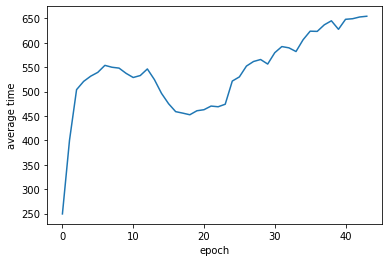

In [ ]:
import matplotlib.pyplot as plt

plt.plot(AVG_TIME)
plt.ylabel('average time')
plt.xlabel('epoch')
plt.show()

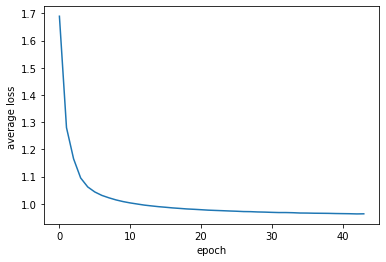

In [ ]:
plt.plot(AVG_LOSS_LIST)
plt.ylabel('average loss ')
plt.xlabel('epoch')
plt.show()

## 2.d) Apply classiﬁer to Bengali data:

####First we will test Bengali data directly on the Classification model (the model we trained for the sole purpose of sentiment analysis of Hindi dataset

First we reload the Bengali data

In [ ]:
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['bengali_hatespeech.csv']))

Saving bengali_hatespeech.csv to bengali_hatespeech.csv


Data preperation

In [ ]:
def data_preperation(data):
  #TODO: implement!



  #remove Punctuations

  data.loc[:, 'sentence'] = data.loc[:,'sentence'].str.replace('[{}]'.format(string.punctuation), "")
  data.loc[:, 'sentence'] = data.loc[:,'sentence'].str.replace(r'\+', "") 
  data.loc[:, 'sentence'] = data.loc[:,'sentence'].str.replace('।', " ")


  #remove Stopwords
  !rm -rf /content/stopwords-bn

  !git clone https://github.com/stopwords-iso/stopwords-bn


  f=open("/content/stopwords-bn/stopwords-bn.txt", "r")

  if f.mode == 'r':
    contents =f.read()

  newcontent = contents.split()



  data['sentence'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (newcontent)]))

  

  #lowercasing the words

  data['sentence'] = data['sentence'].str.lower()


  return data

df = data_preperation(df)

Cloning into 'stopwords-bn'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26
Unpacking objects: 100% (26/26), done.


Next we split off the data just like Task2b

In [ ]:
def splitting(df):
  df = df[5992:14007 ]
  if 'category' in df.columns:
    del df['category']
  return df

data = splitting(df)

In [ ]:
d2 = df[:1]
if 'category' in d2.columns:
    del d2['category']

In [ ]:
data =data.append(d2)

In [ ]:
data

,sentence,hate
5992,মিডিয়ার কুত্তার বাচ্চা জারজ কুলাঙ্গার তুই আলেম...,1
5993,শালার আজকাল ইসলামের ওয়াজ নিয়াও ইউটিউবে ব্যবসা ...,1
5994,লাভ ইউ ভাইয়া চুতমারানী পোলারে চুদা ধন্যবাদ পাশ...,1
5995,রেন্ডির বাচ্চা ভিডিও বানাবি,1
5996,তোর ইউটিউব চ্যানেলে মুতি ছাগল কোথাকার,1
...,...,...
14003,ভালো খারাপ গুরু সবাইকে তেল মারে,0
14004,অমর নায়ক সিলেট অহংকার সালমান সাহ মিস তোমায় মিস...,0
14005,মান্না পাগলী ছবি পাওয়া,0
14006,মত নায়ক পাবো,0


In [ ]:
data = data.sample(frac=1)

In [ ]:
data = data.reset_index()

In [ ]:
data

,index,sentence,hate
0,9519,চুপ কর শালী তুই কাকে খুশি করেছিস,1
1,13151,হালার বিচারকেরাইতো উপযুক্ত বিচার,0
2,7336,এইটা ভাল হইচে নুর সালা তুই পাগল,1
3,6333,কুত্তার বাচ্চা তেদের বিচার আল্লাহ বলবেন,1
4,11868,কুত্তা কুত্তা পুলিশ সুপার হিরো আলম কথা বিকল্প ...,0
...,...,...,...
8011,9516,আপু ছবি করবেই শকিবও ছবি ছড়বে,1
8012,6843,সালার পুতেরা জনগনের রক্ত পানি টাকা দিয়ে ফুটাঙ্...,1
8013,7317,জারা হামলা জানোয়ার চোদা খায় জন্ম হয়ছে,1
8014,11380,সুন্দর লাগলো ভাই আমিও বড় হয়ে ইনশাল্লাহ মত হবো,0


In [ ]:
if 'index' in data.columns:
    del data['index']

In [ ]:
data

,sentence,hate
0,চুপ কর শালী তুই কাকে খুশি করেছিস,1
1,হালার বিচারকেরাইতো উপযুক্ত বিচার,0
2,এইটা ভাল হইচে নুর সালা তুই পাগল,1
3,কুত্তার বাচ্চা তেদের বিচার আল্লাহ বলবেন,1
4,কুত্তা কুত্তা পুলিশ সুপার হিরো আলম কথা বিকল্প ...,0
...,...,...
8011,আপু ছবি করবেই শকিবও ছবি ছড়বে,1
8012,সালার পুতেরা জনগনের রক্ত পানি টাকা দিয়ে ফুটাঙ্...,1
8013,জারা হামলা জানোয়ার চোদা খায় জন্ম হয়ছে,1
8014,সুন্দর লাগলো ভাই আমিও বড় হয়ে ইনশাল্লাহ মত হবো,0


In [ ]:
del df
gc.collect()

331

Create words list and Vocabulary

In [ ]:
WORDSINLIST,V = modules.building_vocabulary(data, 'sentence')

In [ ]:
len(V)

19365

###We create the total word list and Vocabulary

###Initialize Cuda

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


###Now we create CUstom dataset just like what we did for Hindi dataset in Task2a



In [ ]:
class CustomDataset():
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

 

    sentence = self.df['sentence'][idx]
    target = self.df['hate'][idx]


    paddedstr=""
    if len(sentence.split())>=30:
      sentencelist =  sentence.split()[:30]
      sentencestr = ' '.join(sentencelist)
      paddedstr+=sentencestr
    else:
      while len(sentence.split())<30:
        sentence = sentence + ' 0'
      paddedstr+=sentence


    paddedlist = paddedstr.split()


    one_hot_list=[]

    for current in paddedlist:
      current_one_hot = modules.word_to_one_hot(current, V)
      one_hot_list.append(current_one_hot)



    one_hot_list = one_hot_list[:30]
    one_hot_list = torch.FloatTensor(one_hot_list)

    hatespeech = 0
    if target ==0:
      hatespeech=0.0
    else:
      hatespeech = 1.0

    hatespeech = torch.tensor(hatespeech)




    return one_hot_list, hatespeech
  

In [ ]:
customds = CustomDataset(data)

In [ ]:
count=0
for i, j in customds:
  count+=1
  if count==4:
    break
  print(i.shape,  j)


torch.Size([30, 19365]) tensor(1.)
torch.Size([30, 19365]) tensor(0.)
torch.Size([30, 19365]) tensor(1.)


###Create train and test set. 
To be noted, in this subtask we only concerned with testing set, since there is no training.

In [ ]:
train_size = int(0.8 * len(customds))
test_size = len(customds) - train_size

###Create dataloaders

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(customds, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size= 64, shuffle = False, num_workers=0)
testloader = DataLoader(test_dataset, batch_size= 64, shuffle = False, num_workers=0)

###Set some parameters

In [ ]:
embedding_size = 300
learning_rate = 0.03

epochs = 10

###Initialize the model that we use for word embedding

In [ ]:
model = modules.Word2vec( len(V), embedding_size)


###Load the Hindi Word embedding saved from Task1
It will be needed for the hindi sentiment analysis class definition

In [ ]:
PATH = "modelnew.pt"


checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])


model.eval()

Word2vec(
  (FC1): Linear(in_features=19365, out_features=300, bias=False)
  (FC2): Linear(in_features=300, out_features=19365, bias=False)
)

###Now we define and initialize the class used for sentiment analysis

In [ ]:
class Classification(nn.Module):
    def __init__(self, LENGTH, embedding_size):
      super(Classification, self).__init__()
      self.LENGTH = LENGTH
      self.embedding_size = embedding_size

      self.inputl = nn.Linear(self.LENGTH*30, embedding_size,0) # (LENGTH*30, 300)

     # initialization of weights
      torch.nn.init.xavier_normal_(self.inputl.weight) 

      self.FC1 = model.FC1.weight # (300, 19365)
      self.BN1 = nn.BatchNorm1d(19365)

      self.FC2 = model.FC2.weight # (19365, 300)
      self.BN2 = nn.BatchNorm1d(300)
      
      self.FC3 = nn.Linear(300, 1000,0) # (300, 1000)
      self.BN3 = nn.BatchNorm1d(1000)

      self.FC4 = nn.Linear(1000, 2000,0) # (1000, 2000)
      self.BN4 = nn.BatchNorm1d(2000)

      self.FC5 = nn.Linear(2000, 100,0) # (2000, 100)
      self.BN5 = nn.BatchNorm1d(100)

      self.FC6 = nn.Linear(100, 1,0) # (100, 1)

      # initialization of weights
      #torch.nn.init.xavier_normal_(self.output.weight)
      self.drop1 = nn.Dropout2d(p=0.8)
      self.drop2 = nn.Dropout2d(p=0.5)

    def forward(self, one_hot): # one_hot: (64, 30, LENGTH)

      # print(one_hot.shape)
      one_hot = one_hot.reshape(len(one_hot), 30 * self.LENGTH)

      x = self.inputl(one_hot)
      x= F.relu(x)

      x = torch.matmul(x, self.FC1)
      x = self.BN1(x)
      x= F.relu(x)

      x = torch.matmul(x, self.FC2)
      x = self.BN2(x)
      x= F.relu(x)

      x = self.FC3(x)
      x = self.BN3(x)
      x= F.relu(x)
      x = self.drop1(x)

      x = self.FC4(x)
      x = self.BN4(x)
      x= F.relu(x)

      x = self.FC5(x)
      x = self.BN5(x)
      x= F.relu(x)
      x = self.drop2(x)

      x = self.FC6(x)

      m = nn.Sigmoid()
      x = m(x)

      return x

In [ ]:
classification = Classification(len(V), embedding_size)

###Now we will load the hindi sentiment analysis that we saved in task2a

In [ ]:
PATH = "/content/model_task2.pt"

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
classification.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

classification.eval()

Classification(
  (inputl): Linear(in_features=580950, out_features=300, bias=False)
  (BN1): BatchNorm1d(19365, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC3): Linear(in_features=300, out_features=1000, bias=False)
  (BN3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC4): Linear(in_features=1000, out_features=2000, bias=False)
  (BN4): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC5): Linear(in_features=2000, out_features=100, bias=False)
  (BN5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC6): Linear(in_features=100, out_features=1, bias=False)
  (drop1): Dropout2d(p=0.8, inplace=False)
  (drop2): Dropout2d(p=0.5, inplace=False)
)

###Set optimizer and loss function

In [ ]:
optimizer = torch.optim.Adam(classification.parameters(), lr = learning_rate)

criterion = nn.BCELoss()

###Now we will test 
As you can see, there is no training!!

In [ ]:
#test the model..
AVG_LOSS_LIST = []
AVG_TIME = []


def test(test_dl, LENGTH):
    print("Testing started")

    start_time = time.time()
    avg_loss = 0
    count = 0
    hitcount=0
    for xb,yb in test_dl: 
      
      
      # 1. Generate predictions
      optimizer.zero_grad()
      # print(xb.shape)
    
      pred = classification(xb)

      

      # pred = pred.squeeze(1)


      # if (pred - yb)==0:
      #   hitcount=hitcount+1

      # print(pred)
      # print(yb)

      ybcount=-1
      for i in pred:
        
        count+=1
        ybcount+=1
        # print(i, yb[ybcount])
        if i <0.5:
          if torch.eq(yb[ybcount], torch.tensor(0.0)):
            hitcount=hitcount+1
        elif i>=.5:
          if torch.eq(yb[ybcount], torch.tensor(1.0)):
            hitcount=hitcount+1



      

      # 2. Calculate loss
      
      yb = yb.unsqueeze(1)

      loss = criterion(pred, yb)


      avg_loss+=loss
      

 

    # Print the progress
    print('avg loss at epoch ', avg_loss/count)
    remaining = (time.time() - start_time)
    print("--- %s seconds ---" % remaining)
    AVG_LOSS_LIST.append(avg_loss/count)
    AVG_TIME.append(remaining)

    print('accuracy:', hitcount/count)


test(testloader, len(V))

print("Testing finished")

Testing started
avg loss at epoch  tensor(0.0357, grad_fn=<DivBackward0>)
--- 557.9914381504059 seconds ---
accuracy: 0.48316708229426436
Testing finished


##ACCURACY REPORT WHEN TEST HINDI SENTIMENT ANALYSIS MODEL DIRECTLY ON BENGALI DATA WITHOUT NO FURTHER TRAINING:
**As we can see the Accuracy which is 48% is really not optimistic. So it states that without re-training the model on Bengali data, the model which is only trained in Hindi data will not give a good sentiment analysis**

###Next we will load the hindi sentiment analysis model but this time we will train it first with Bengali dataset.

After training we will test it with test data

In [ ]:
#train the model..
AVG_LOSS_LIST = []
AVG_TIME = []
def train(train_dl, LENGTH):
    print("Training started")
    lastone = 9999
    
    for epoch in range(epochs):
        start_time = time.time()
        avg_loss = 0
        count = 0

        for xb,yb in train_dl: 

          xb = xb.to(device)
          yb = yb.to(device)

         
          
          # 1. Generate predictions
          optimizer.zero_grad()
          print('New x, label generated')

          print(yb.shape)
        
          pred = classification(xb)

         
          # 2. Calculate loss
          
          yb = yb.unsqueeze(1)

          loss = criterion(pred, yb)

         
          avg_loss+=loss
          count+=1
          # 3. Compute gradients
          loss.backward()
              
          # 4. Update parameters using gradients
          optimizer.step()
              
          # 5. Reset the gradients to zero
          #optimizer.zero_grad()
        
        

        # Print the progress
        print('avg loss at epoch ', epoch, ' ', avg_loss/count)
        remaining = (time.time() - start_time)
        print("--- %s seconds ---" % remaining)
        AVG_LOSS_LIST.append(avg_loss/count)
        AVG_TIME.append(remaining)

        # Terminating Condition
        if (avg_loss/count)> lastone:
          return
        lastone = (avg_loss/count)

train(trainloader, len(V))

print("Training finished")

Training started
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated


###Now we will test the model

In [ ]:
#test the model..
AVG_LOSS_LIST = []
AVG_TIME = []


def test(test_dl, LENGTH):
    print("Testing started")

    start_time = time.time()
    avg_loss = 0
    count = 0
    hitcount=0
    for xb,yb in test_dl: 

      xb = xb.to(device)
      yb = yb.to(device)

         
      
      
      # 1. Generate predictions
      optimizer.zero_grad()
      # print(xb.shape)
    
      pred = classification(xb)

      

      # pred = pred.squeeze(1)


      # if (pred - yb)==0:
      #   hitcount=hitcount+1

      # print(pred)
      # print(yb)

      ybcount=-1
      for i in pred:
        
        count+=1
        ybcount+=1
        # print(i, yb[ybcount])
        if i <0.5:
          if torch.eq(yb[ybcount], torch.tensor(0.0)):
            hitcount=hitcount+1
        elif i>=.5:
          if torch.eq(yb[ybcount], torch.tensor(1.0)):
            hitcount=hitcount+1



      

      # 2. Calculate loss
      
      yb = yb.unsqueeze(1)

      loss = criterion(pred, yb)


      avg_loss+=loss
      

 

    # Print the progress
    print('avg loss at epoch ', avg_loss/count)
    remaining = (time.time() - start_time)
    print("--- %s seconds ---" % remaining)
    AVG_LOSS_LIST.append(avg_loss/count)
    AVG_TIME.append(remaining)

    print('accuracy:', hitcount/count)


test(testloader, len(V))

print("Testing finished")

Testing started
avg loss at epoch  tensor(0.1620, grad_fn=<DivBackward0>)
--- 481.49974608421326 seconds ---
accuracy: 0.8379052369077307
Testing finished


##ACCURACY REPORT WHEN WE TRAIN THE HINDI SENTIMENT ANALYSIS MODEL WITH BENGALI DATA BEFORE GOING FOR TESTING:
**As we can see, we have an accuracy of 84%**

###Now we will save the model

In [ ]:
drive.mount('/drive')
PATH = "model_hindi_bengalidata.pt"

torch.save({
          'model_state_dict': classification.state_dict(),
          }, PATH)

#### Next we will load the Bengali word embedding model (saved in Task 2c) and train and test sentiment analysis on Bengali data (similar to what we did in Task 2a for Hindi data)

We already have the data, and also the custom dataset and training and testing dataloader. 

So we will just start from loading Bengali word embedding

In [ ]:
model = modules.Word2vec( 19365, embedding_size)


In [ ]:
PATH = "/content/model_task2c.pt"

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

Word2vec(
  (FC1): Linear(in_features=19365, out_features=300, bias=False)
  (FC2): Linear(in_features=300, out_features=19365, bias=False)
)

###Define the sentiment analysis class and initialize it

In [ ]:
class Classification(nn.Module):
    def __init__(self, LENGTH, embedding_size):
      super(Classification, self).__init__()
      self.LENGTH = LENGTH
      self.embedding_size = embedding_size

      self.inputl = nn.Linear(self.LENGTH*30, embedding_size,0) # (LENGTH*30, 300)

     # initialization of weights
      torch.nn.init.xavier_normal_(self.inputl.weight) 

      self.FC1 = model.FC1.weight # (300, 19365)
      self.BN1 = nn.BatchNorm1d(19365)

      self.FC2 = model.FC2.weight # (19365, 300)
      self.BN2 = nn.BatchNorm1d(300)
      
      self.FC3 = nn.Linear(300, 1000,0) # (300, 1000)
      self.BN3 = nn.BatchNorm1d(1000)

      self.FC4 = nn.Linear(1000, 2000,0) # (1000, 2000)
      self.BN4 = nn.BatchNorm1d(2000)

      self.FC5 = nn.Linear(2000, 100,0) # (2000, 100)
      self.BN5 = nn.BatchNorm1d(100)

      self.FC6 = nn.Linear(100, 1,0) # (100, 1)

      # initialization of weights
      #torch.nn.init.xavier_normal_(self.output.weight)
      self.drop1 = nn.Dropout2d(p=0.8)
      self.drop2 = nn.Dropout2d(p=0.5)

    def forward(self, one_hot): # one_hot: (64, 30, LENGTH)

      # print(one_hot.shape)
      one_hot = one_hot.reshape(len(one_hot), 30 * self.LENGTH)

      x = self.inputl(one_hot)
      x= F.relu(x)

      x = torch.matmul(x, self.FC1)
      x = self.BN1(x)
      x= F.relu(x)

      x = torch.matmul(x, self.FC2)
      x = self.BN2(x)
      x= F.relu(x)

      x = self.FC3(x)
      x = self.BN3(x)
      x= F.relu(x)
      x = self.drop1(x)

      x = self.FC4(x)
      x = self.BN4(x)
      x= F.relu(x)

      x = self.FC5(x)
      x = self.BN5(x)
      x= F.relu(x)
      x = self.drop2(x)

      x = self.FC6(x)

      m = nn.Sigmoid()
      x = m(x)

      return x

In [ ]:
classification = Classification(len(V), embedding_size)

###Set optimizer and loss function

In [ ]:
optimizer = torch.optim.Adam(classification.parameters(), lr = learning_rate)

criterion = nn.BCELoss()

In [ ]:
classification = classification.to(device)
criterion = criterion.to(device)

###Train the model
TO be noted, we have used Bengali word embedding model to train it

In [ ]:
#train the model..
AVG_LOSS_LIST = []
AVG_TIME = []
def train(train_dl, LENGTH):
    print("Training started")
    lastone = 9999
    
    for epoch in range(epochs):
        start_time = time.time()
        avg_loss = 0
        count = 0

        for xb,yb in train_dl: 

          xb = xb.to(device)
          yb = yb.to(device)

         
          
          # 1. Generate predictions
          optimizer.zero_grad()
          print('New x, label generated')

          print(yb.shape)
        
          pred = classification(xb)

         
          # 2. Calculate loss
          
          yb = yb.unsqueeze(1)

          loss = criterion(pred, yb)

         
          avg_loss+=loss
          count+=1
          # 3. Compute gradients
          loss.backward()
              
          # 4. Update parameters using gradients
          optimizer.step()
              
          # 5. Reset the gradients to zero
          #optimizer.zero_grad()
        
        

        # Print the progress
        print('avg loss at epoch ', epoch, ' ', avg_loss/count)
        remaining = (time.time() - start_time)
        print("--- %s seconds ---" % remaining)
        AVG_LOSS_LIST.append(avg_loss/count)
        AVG_TIME.append(remaining)

        # Terminating Condition
        if (avg_loss/count)> lastone:
          return
        lastone = (avg_loss/count)

train(trainloader, len(V))

print("Training finished")

Training started
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated
torch.Size([64])
New x, label generated


###Now we test it on test dataset

In [ ]:
#test the model..
AVG_LOSS_LIST = []
AVG_TIME = []


def test(test_dl, LENGTH):
    print("Testing started")

    start_time = time.time()
    avg_loss = 0
    count = 0
    hitcount=0
    for xb,yb in test_dl: 

      xb = xb.to(device)
      yb = yb.to(device)

         
      
      
      # 1. Generate predictions
      optimizer.zero_grad()
      # print(xb.shape)
    
      pred = classification(xb)

      

      # pred = pred.squeeze(1)


      # if (pred - yb)==0:
      #   hitcount=hitcount+1

      # print(pred)
      # print(yb)

      ybcount=-1
      for i in pred:
        
        count+=1
        ybcount+=1
        # print(i, yb[ybcount])
        if i <0.5:
          if torch.eq(yb[ybcount], torch.tensor(0.0)):
            hitcount=hitcount+1
        elif i>=.5:
          if torch.eq(yb[ybcount], torch.tensor(1.0)):
            hitcount=hitcount+1



      

      # 2. Calculate loss
      
      yb = yb.unsqueeze(1)

      loss = criterion(pred, yb)


      avg_loss+=loss
      

 

    # Print the progress
    print('avg loss at epoch ', avg_loss/count)
    remaining = (time.time() - start_time)
    print("--- %s seconds ---" % remaining)
    AVG_LOSS_LIST.append(avg_loss/count)
    AVG_TIME.append(remaining)

    print('accuracy:', hitcount/count)


test(testloader, len(V))

print("Testing finished")

Testing started
avg loss at epoch  tensor(0.0177, device='cuda:0', grad_fn=<DivBackward0>)
--- 319.8833885192871 seconds ---
accuracy: 0.8322942643391521
Testing finished


##ACCURACY REPORT WHEN WE CREATE BENGALI SENTIMENT ANALYSIS MODEL USING BENGALI WORD EMBEDDING MODEL (FROM 2C) AND TRAIN IT BEFORE TESTING
**As we can see, there is an accuracy of 83%**

##Now we will save the model

In [ ]:
drive.mount('/drive')
PATH = "model_bengalidata.pt"

torch.save({
          'model_state_dict': classification.state_dict(),
          }, PATH)

Mounted at /drive
